In [2]:
import random
import matplotlib.pyplot as plt

from collections import deque

import pennylane as qml
from pennylane.templates import ApproxTimeEvolution
from pennylane import numpy as np
import itertools


In [3]:
class TSP:
    def __init__(self, number_of_cities, coords_range=(0, 10000)):
        self.number_of_cities = number_of_cities
        self.coords_range = coords_range
        self.cities_coords = self.get_cities()
        self.distance_matrix = self.calculate_distance_matrix()
        self.normalized_distance_matrix = self.normalize_distance_matrix()
    
    def get_cities(self):
        cities_coords = np.random.randint(self.coords_range[0], self.coords_range[1], size = (self.number_of_cities, 2))
        return cities_coords
           
    def normalize_cities(self):
        max_coords = np.amax(self.cities_coords, axis=0)
        normalized_cities_coords = np.divide(self.cities_coords, max_coords)
        return normalized_cities_coords

    def calculate_distance_between_points(self, point_A, point_B):
        return np.sqrt((point_A[0] - point_B[0])**2 + (point_A[1] - point_B[1])**2)
    
    def calculate_distance_matrix(self):
        distance_matrix = np.zeros((self.number_of_cities, self.number_of_cities))
        for i in range(self.number_of_cities):
            for j in range(i, self.number_of_cities):
                distance_matrix[i][j] = self.calculate_distance_between_points(self.cities_coords[i], self.cities_coords[j])
                distance_matrix[j][i] = distance_matrix[i][j]
        return distance_matrix 
    
    def normalize_distance_matrix(self):
        return np.divide(self.distance_matrix, np.max(self.distance_matrix))


In [194]:
class QAOA_TSP:
    def __init__(self, tsp_instance, A_1=4, A_2=4, B=1):
        self.tsp_instance = tsp_instance
        self.weights = {'cost_weight': B, 
                        'constraint_each_visited': A_1, 
                        'constraint_each_visited_once': A_2}
        self.cost_operator = self.create_cost_operator()
    
    def calc_bit(self, i, t):
        return i + t * self.tsp_instance.number_of_cities

    def x(self, i, t):
        wire = self.calc_bit(i, t)
        return qml.Hamiltonian([0.5, -0.5], [qml.Identity(wire), qml.PauliZ(wire)])

    def create_cost_operator(self):
        A_1 = self.weights['constraint_each_visited']
        A_2 = self.weights['constraint_each_visited_once']
        B = self.weights['cost_weight']
        
        cost_of_constraint_each_visited = 0    
        for i in range(self.tsp_instance.number_of_cities):
            curr = qml.Identity(0)
            for t in range(self.tsp_instance.number_of_cities):
                curr -= self.x(i, t)    
            for t1 in range(self.tsp_instance.number_of_cities):
                for t2 in range(t1 + 1, self.tsp_instance.number_of_cities):
                    curr += 2 * self.x(i, t1) @ self.x(i, t2)
            cost_of_constraint_each_visited += curr
        cost_of_constraint_each_visited_once = 0
        for t in range(self.tsp_instance.number_of_cities):
            curr = qml.Identity(0)
            for i in range(self.tsp_instance.number_of_cities):
                curr -= self.x(i, t)
            for i1 in range(self.tsp_instance.number_of_cities):
                for i2 in range(i1 + 1, self.tsp_instance.number_of_cities):
                    curr += 2 * self.x(i1, t) @ self.x(i2, t)
            cost_of_constraint_each_visited += curr
        
        cost_of_visiting_cities = 0
        for i, j in itertools.permutations(range(0, self.tsp_instance.number_of_cities), 2):
            curr = qml.Identity(0)
            for t in range(self.tsp_instance.number_of_cities):
                inc_t = t + 1
                if inc_t == self.tsp_instance.number_of_cities:
                    inc_t = 0
                curr += self.x(i, t) @ self.x(j, inc_t)
            cost_of_visiting_cities += float(self.tsp_instance.normalized_distance_matrix[i][j]) * curr 
        
        cost_operator = (
            A_1 * cost_of_constraint_each_visited + 
            A_2 * cost_of_constraint_each_visited_once +
            B * cost_of_visiting_cities
        )
                
        return cost_operator

In [195]:
def hadamard_layer(wires):
    for i in range(wires):
        qml.Hadamard(i)

In [196]:
def create_mixing_hamitonian(wires, const=1/2):
    hamiltonian = qml.Identity(0)
    for i in range(wires):
        hamiltonian += qml.Hamiltonian([const], [qml.PauliX(i)])
    # ApproxTimeEvolution(hamiltonian, time, 1)
    return hamiltonian

In [277]:
n = 4
tsp_instance = TSP(n)
qaoa_tsp = QAOA_TSP(tsp_instance, A_1=4, A_2=4, B=1)

In [278]:
print(tsp_instance.cities_coords)

[[1759 6876]
 [3424 7626]
 [ 927 7933]
 [2080 4367]]


In [279]:
def qaoa_layer(gamma, beta):
    qml.qaoa.cost_layer(gamma, qaoa_tsp.cost_operator)
    qml.qaoa.mixer_layer(beta, create_mixing_hamitonian(n**2))

In [280]:
def circuit(params, n_layers=2):
    hadamard_layer(n**2)
    qml.layer(qaoa_layer, n_layers, params[0], params[1])

In [281]:
dev = qml.device("default.qubit", wires=n**2)


@qml.qnode(dev)
def cost_function(params):
    circuit(params, n_layers=6)
    x = qml.expval(qaoa_tsp.cost_operator)
    return x

In [291]:
# fig, ax = qml.draw_mpl(circuit, expansion_strategy="device")([[0, 0], [0, 0]], knapsack)
# fig.show()
optimizer = qml.AdamOptimizer()
steps = 70
params = np.array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]], requires_grad=True)

/tmp/ipykernel_11901/3773707193.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


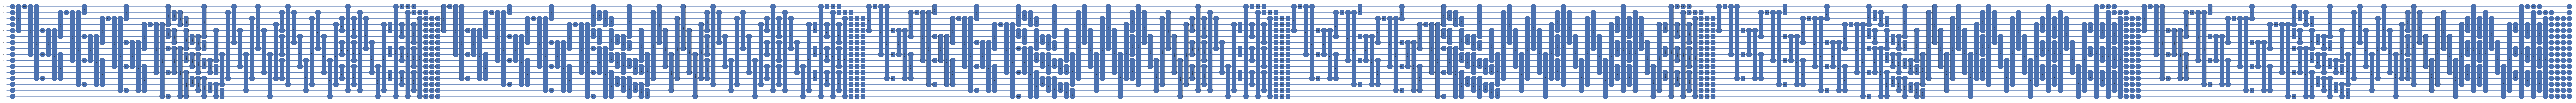

In [292]:
fig, ax = qml.draw_mpl(cost_function, expansion_strategy="device")(params)
fig.show()

In [293]:
for i in range(steps):
    params = optimizer.step(cost_function, params)
    if i % 5 == 0:
        print(params)

print("Optimal Parameters")
print(params)

[[0.51       0.51       0.49       0.49       0.49       0.49      ]
 [0.51       0.50999999 0.49       0.51       0.51       0.51      ]]
[[0.54161981 0.52126357 0.48978242 0.48994341 0.47835374 0.45856919]
 [0.55805656 0.49056579 0.44021531 0.53228197 0.54506535 0.4932784 ]]
[[0.5364675  0.48739051 0.48648118 0.50846037 0.48478967 0.45176518]
 [0.59680613 0.49512172 0.39312915 0.55014658 0.58132129 0.44791929]]
[[0.54807833 0.48085837 0.48540719 0.50872898 0.4904769  0.45392665]
 [0.6070028  0.47128428 0.35019029 0.57351693 0.56639729 0.42028018]]
[[0.56676049 0.48455394 0.48090028 0.50212302 0.5074023  0.46419005]
 [0.59148774 0.44255455 0.30968364 0.59784837 0.53039628 0.39868042]]
[[0.5812907  0.47424278 0.46020422 0.50178406 0.53036798 0.47524822]
 [0.57823068 0.42905952 0.26893655 0.6250661  0.49656348 0.38504967]]
[[0.60347333 0.46553544 0.45399873 0.5110568  0.52696165 0.4708943 ]
 [0.59108271 0.44411689 0.22425826 0.65039411 0.47342907 0.39568217]]
[[0.63663221 0.44587671 0.4

In [294]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha], n_layers=6)
    return qml.probs(wires=range(n**2))

probs = probability_circuit(params[0], params[1])

In [295]:
# plt.style.use("seaborn")
# plt.bar(range(2 ** (n_wires)), probs)
# plt.show()
print(probs)

[3.18414933e-06 1.18815350e-05 5.15169788e-06 ... 9.11176807e-07
 2.40989567e-07 6.70987026e-07]


In [297]:
correct_results = ("0001100001000010","0010010010000001","0100100000010010","1000000100100100","1000010000100001","0100001000011000","0001001001001000","0010000110000100","0100000110000010","0010100000010100","0001010000101000","0001100000100100","1000000101000010","1000001001000001","0100001010000001", "0100000100101000", "0010010000011000", "0100100000100001", "1000001000010100", "0001001010000100", "0001010010000010","0010000101001000", "1000010000010010", "0010100001000001")
result_dict = {key: float(val) for key, val in enumerate(probs)}
result_dict = dict(sorted(result_dict.items(), key=lambda item: item[1], reverse=True))


In [298]:
get_bin = lambda x, n: format(x, 'b').zfill(n)
for key, val in result_dict.items():
    print(f"Key: {get_bin(key, 16)} with probability {val}   | correct: {'True' if get_bin(key, 16) in correct_results else 'False'}")

Key: 0010010000011000 with probability 0.003089380420497887   | correct: True
Key: 0001100000100100 with probability 0.003089380420497886   | correct: True
Key: 1000000101000010 with probability 0.0030893804204978844   | correct: True
Key: 0100001010000001 with probability 0.0030893804204978783   | correct: True
Key: 0100000110000010 with probability 0.0030893804204978766   | correct: True
Key: 1000001001000001 with probability 0.0030893804204978723   | correct: True
Key: 0001010000101000 with probability 0.0030893804204978714   | correct: True
Key: 0010100000010100 with probability 0.0030893804204978705   | correct: True
Key: 1000010000010010 with probability 0.0029043394736205266   | correct: True
Key: 0001001010000100 with probability 0.0029043394736205244   | correct: True
Key: 0100000100101000 with probability 0.0029043394736205236   | correct: True
Key: 0010000101001000 with probability 0.002904339473620522   | correct: True
Key: 0100100000100001 with probability 0.00290433947362

In [ ]:
plt.style.use("seaborn")
plt.bar(range(2 ** (n ** 2)), probs)
plt.show()